# Rare Event Binary Classification using Autoencoder

Here we will show an implementation of building a binary classifier using Autoencoders. The purpose is to show the implementation steps. The Autoencoder tuning for performance improvement can be done.

The dataset used here is taken from here,

**Dataset: Rare Event Classification in Multivariate Time Series** https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

## Reading and preparing data

In [ ]:
df = pd.read_csv("data/processminer-rare-event-mts - data.csv") 
df.head(n=5)  # visualize the data.

### Shift the data

This is a timeseries data in which we have to predict the event (y = 1) ahead in time. In this data, consecutive rows are 2 minutes apart. We will shift the labels in column `y` by 2 rows to do a 4 minute ahead prediction.

In [ ]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by, labelcol = 'y'):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column.
    shift_by An integer denoting the number of rows to shift.
    labelcol The column containing the binary labels. Default 'y'.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

In [4]:
df.loc[df['y'] == 1].head(n=5)  # Positive labeled rows before shifting.

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
259,5/1/99 8:38,1,0.892311,-13.332664,-10.006578,2.855933,-0.448832,15.986336,0.000732,-0.061114,...,11.280929,-0.752385,-5.015553,-75.896664,69.585016,3.113292,0.032223,5.685793,0.007663,1
776,5/2/99 4:02,1,-0.782471,-12.118747,-16.855194,-322.781610,-0.738810,25.966042,0.040711,-0.071186,...,0.324387,-5.337590,2.680329,-7.209775,-37.195777,1.642284,0.013798,2.664362,0.007856,0
835,5/2/99 6:24,1,-0.697450,-1.696176,4.145142,121.152838,-0.598597,-7.789024,0.060853,0.048752,...,-1.685379,-6.368351,2.568616,-26.245907,-74.477362,-0.097278,0.015905,2.700281,0.007745,0
1036,5/2/99 13:08,1,-0.791718,-0.076644,-1.012134,162.257269,-0.062876,9.005471,0.005767,0.033764,...,-2.757156,-6.856144,2.703874,-29.833432,-53.421866,-1.165393,0.019691,3.348276,0.006241,0
1263,5/2/99 20:42,1,-1.212083,-2.326809,0.922287,31.935859,-0.920100,14.183205,-0.089298,0.028915,...,-2.757156,-6.856144,2.762956,0.965763,-49.512961,-0.219349,0.041640,2.740404,0.005131,0


In [5]:
# Shift the response column y by 2 rows to do a 4-min ahead prediction.

df = curve_shift(df, shift_by = -2)

In [6]:
df.loc[df['y'] == 1].head(n=5)  # Validating if the shift happened correctly.

,y,time,x1,x2,x3,x4,x5,x6,x7,x8,...,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
257,1.0,5/1/99 8:34,1.005602,-3.876199,-1.074373,0.844397,-0.553050,14.738228,0.000732,-0.061114,...,11.271652,-0.752385,-5.015364,-69.553891,70.500879,4.050182,0.031596,3.746714,0.007695,0
258,1.0,5/1/99 8:36,0.933933,-3.868467,-1.249954,2.875311,-0.500941,15.643990,0.000732,-0.061114,...,11.276291,-0.752385,-5.015458,-75.298153,68.812829,3.473400,0.032007,4.712130,0.007679,0
774,1.0,5/2/99 3:58,-0.738480,-4.604522,5.133959,-322.781610,-0.485865,23.919441,0.030640,-0.081257,...,0.381027,-5.308781,2.682929,-54.851986,-38.804999,1.031932,0.014034,4.182024,0.007835,0
775,1.0,5/2/99 4:00,-0.706759,-6.442805,-0.920200,-322.781610,-0.612330,24.906838,0.040711,-0.071186,...,0.352707,-5.323185,2.681629,-56.460751,-38.000388,1.031932,0.013916,3.825068,0.007845,0
833,1.0,5/2/99 6:20,-0.629733,-1.964926,4.587883,117.531806,-0.577403,-8.266746,0.070619,0.008773,...,-1.628738,-6.339299,2.572946,-26.438168,-67.357718,-0.219349,0.015600,3.994639,0.007759,0


In [7]:
# Remove time column, and the categorical columns
df = df.drop(['time', 'x28', 'x61'], axis=1)

### Divide the data into train, valid, and test

In [8]:
df_train, df_test = train_test_split(df, test_size=DATA_SPLIT_PCT, random_state=SEED)
df_train, df_valid = train_test_split(df_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In the autoencoder, we will be encoding only the negatively labeled data. That is, we will take the part of data for which `y=0` and build an autoencoder. For that, we will divide the datasets as following.

In [9]:
df_train_0 = df_train.loc[df['y'] == 0]
df_train_1 = df_train.loc[df['y'] == 1]
df_train_0_x = df_train_0.drop(['y'], axis=1)
df_train_1_x = df_train_1.drop(['y'], axis=1)

df_valid_0 = df_valid.loc[df['y'] == 0]
df_valid_1 = df_valid.loc[df['y'] == 1]
df_valid_0_x = df_valid_0.drop(['y'], axis=1)
df_valid_1_x = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df['y'] == 0]
df_test_1 = df_test.loc[df['y'] == 1]
df_test_0_x = df_test_0.drop(['y'], axis=1)
df_test_1_x = df_test_1.drop(['y'], axis=1)

### Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

In [10]:
scaler = StandardScaler().fit(df_train_0_x)
df_train_0_x_rescaled = scaler.transform(df_train_0_x)
df_valid_0_x_rescaled = scaler.transform(df_valid_0_x)
df_valid_x_rescaled = scaler.transform(df_valid.drop(['y'], axis = 1))

df_test_0_x_rescaled = scaler.transform(df_test_0_x)
df_test_x_rescaled = scaler.transform(df_test.drop(['y'], axis = 1))

## Autoencoder training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [11]:
nb_epoch = 100
batch_size = 128
input_dim = df_train_0_x_rescaled.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(df_train_0_x_rescaled, df_train_0_x_rescaled,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_valid_0_x_rescaled, df_valid_0_x_rescaled),
                    verbose=1,
                    callbacks=[cp, tb]).history

Instructions for updating:
Use tf.cast instead.
Train on 11541 samples, validate on 2883 samples
Epoch 1/100
11541/11541 [==============================] - 0s 26us/step - loss: 2.7912 - acc: 0.0555 - val_loss: 2.2734 - val_acc: 0.0947
Epoch 2/100
11541/11541 [==============================] - 0s 13us/step - loss: 1.9443 - acc: 0.1045 - val_loss: 1.6102 - val_acc: 0.0884
Epoch 3/100
11541/11541 [==============================] - 0s 13us/step - loss: 1.4259 - acc: 0.0889 - val_loss: 1.2487 - val_acc: 0.0930
Epoch 4/100
11541/11541 [==============================] - 0s 12us/step - loss: 1.1713 - acc: 0.0949 - val_loss: 1.0740 - val_acc: 0.0992
Epoch 5/100
11541/11541 [==============================] - 0s 13us/step - loss: 1.0381 - acc: 0.1184 - val_loss: 0.9767 - val_acc: 0.1280
Epoch 6/100
11541/11541 [==============================] - 0s 13us/step - loss: 0.9609 - acc: 0.1503 - val_loss: 0.9188 - val_acc: 0.1547
Epoch 7/100
11541/11541 [==============================] - 0s 12us/step - l

11541/11541 [==============================] - 0s 12us/step - loss: 0.6812 - acc: 0.4799 - val_loss: 0.6688 - val_acc: 0.4592
Epoch 58/100
11541/11541 [==============================] - 0s 12us/step - loss: 0.6796 - acc: 0.4762 - val_loss: 0.6667 - val_acc: 0.4544
Epoch 59/100
11541/11541 [==============================] - 0s 15us/step - loss: 0.6802 - acc: 0.4773 - val_loss: 0.6687 - val_acc: 0.4860
Epoch 60/100
11541/11541 [==============================] - 0s 14us/step - loss: 0.6819 - acc: 0.4794 - val_loss: 0.6675 - val_acc: 0.4707
Epoch 61/100
11541/11541 [==============================] - 0s 15us/step - loss: 0.6794 - acc: 0.4794 - val_loss: 0.6658 - val_acc: 0.4707
Epoch 62/100
11541/11541 [==============================] - 0s 15us/step - loss: 0.6771 - acc: 0.4831 - val_loss: 0.6733 - val_acc: 0.4589
Epoch 63/100
11541/11541 [==============================] - 0s 14us/step - loss: 0.6851 - acc: 0.4751 - val_loss: 0.6642 - val_acc: 0.4797
Epoch 64/100
11541/11541 [==============

In [13]:
autoencoder = load_model('autoencoder_classifier.h5')

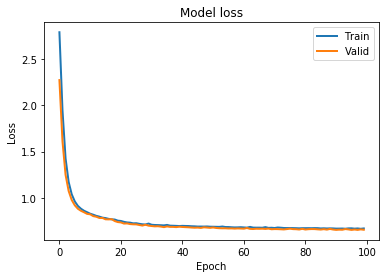

In [14]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

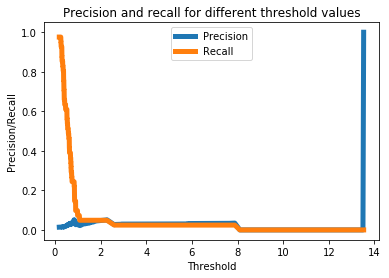

In [15]:
valid_x_predictions = autoencoder.predict(df_valid_x_rescaled)
mse = np.mean(np.power(df_valid_x_rescaled - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [16]:
test_x_predictions = autoencoder.predict(df_test_x_rescaled)
mse = np.mean(np.power(df_test_x_rescaled - test_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})
error_df_test = error_df_test.reset_index()

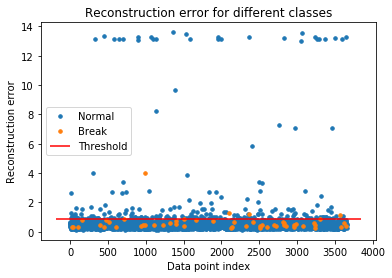

In [27]:
threshold_fixed = 0.85
groups = error_df_test.groupby('True_class')

fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [28]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]


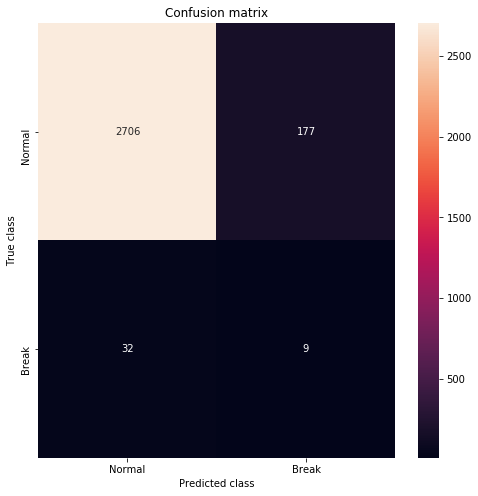

In [29]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

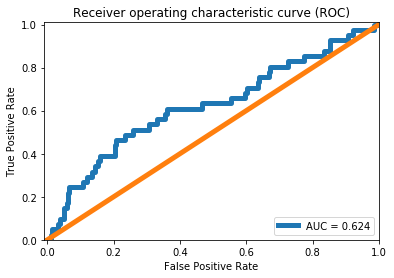

In [30]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()